# Previsão de Demanda de Vinhos com Séries Temporais

A **Previsão de Demanda** é um processo crucial para as empresas, pois **visa antecipar a disposição dos clientes em adquirir um produto a um determinado preço**. Para realizar essa previsão, são analisados dados históricos de vendas e levados em consideração diversos fatores que podem influenciar a demanda futura de um produto. A previsão de demanda abrange aspectos como elaboração de orçamentos, planejamento e preparação da produção, gestão de estoques, definição de preços e promoções, entre outros.

<p align = "center">
<img src="Arquivos/wine.jpg" width=80%>
</p>

O **objetivo** deste projeto é **realizar a previsão das vendas de vinhos utilizando séries temporais**. As séries temporais são conjuntos de dados coletados em intervalos regulares de tempo, permitindo observar padrões, sazonalidades e tendências ao longo do tempo. No caso deste projeto, serão analisados **dados sintéticos** baseados em uma competição do *Kaggle*.

Os **vinhos** são bebidas que evoluem continuamente, **exigindo condições ideais de armazenamento e transporte** para preservar suas características e evitar a deterioração. Por esse motivo, é essencial ter cuidado especial com a guarda e o transporte dos vinhos, de modo a ****minimizar perdas no estoque e maximizar o lucro da empresa**.

Embora alguns vinhos possam melhorar com o passar dos anos, a maioria é produzida para consumo "imediato", desde o momento em que chegam ao mercado até, no máximo, 1 a 3 anos. Portanto, é fundamental evitar o acúmulo de vinhos no estoque, otimizando o gerenciamento de demanda e garantindo a satisfação do cliente, bem como a saúde financeira da empresa.

## Aquisição dos Dados

Há dois arquivos disponíveis, baseados no *Kaggle*, criados pelo Rafael Duarte, que serão analizados. O primeiro disponível [aqui](https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/products.csv) trata de informações sobre o produto. A primeira análise será sobre o mesmo a fim de entender melhor o rpoblema.

O próximo conjunto de dados é relacionado às vendas, disponível [aqui](https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/sales-clean.csv). Neste conjunto é onde será utilizado a série temporal com o objetivo de prever a demanda.

In [255]:
# Importação de bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [256]:
# importar os dados
df_product = pd.read_csv("https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/products.csv")

store = pd.read_csv("https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/sales-clean.csv")

## Análise dos Dados

Esta etapa tem por objetivo permitir um entendimento de como os dados estão estruturados.

**Dicionário das variáveis**

* `item_id`- Número de identificação do item
* `name`- Nome do vinho
* `producer`- Nome do Produtor do vinho
* `country`- País de origem do vinho
* `vintage`- Safra
* `kind`- Tipo do vinho
* * Sparkling = Espumante
* * Rose Sparkling = Espumante Rose
* * White = Branco
* * Rosé = Rosé
* * Red = Tinto
* `price_brl`- Preço em reais
* `price_usd`- Preço em dólar americano

## Análise Exploratória dos Dados

Na análise exploratória de dados será efetuada uma explanação inicial das variáveis contidas na dataset, e entenderemos dados referentes a:

* *Contexto geral das variáveis*
* *Porcentagem de itens nulos*
* *Análise das variáveis separadas por seus respectivos grupos*
* *Divisão do conjunto de treino e teste*
* *Auto-ML*
* *Previsão em dados novos*


Primeiramente, observaremos como estão dispostas as cinco primeiras entradas do dataset para ter uma visão ampla da estrutura de dados.

In [257]:
df_product.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,NV,rose sparkling,489.00,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.00,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.40,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,"1,548.00",267.82


In [258]:
# Visualizar o tamanho do dataframe
print("Entradas: ", df_product.shape[0])
print("Variáveis: ", df_product.shape[1])

Entradas:  219
Variáveis:  9


In [259]:
# Extrair o nome das colunas
df_product.columns

Index(['item_id', 'name', 'producer', 'country', 'region', 'vintage', 'kind',
       'price_brl', 'price_usd'],
      dtype='object')

O dataset contém **219 instâncias** e **9 features**. Observando as 5 primeiras entradas é possível identificar alguns problemas que devem ser corrigidos:

* A feature "price_brl" possui algumas vírgulas, que não vão ser bem interpretadas pelo Python.
* A safra, ou vintage, possui valores como NV (Non-Vintage) que devem ser alterados para 0.

Corrigiremos estes problemas a seguir.

In [260]:
# limpando as vírgulas
df_product.replace(',','', regex=True, inplace=True)
# removendo o NV da safra
df_product.vintage = df_product.vintage.replace('NV', '0')
df_product.vintage = pd.to_numeric(df_product.vintage)
# visualizando o dataset
df_product.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.60,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,0,rose sparkling,489.00,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.00,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.40,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,1548.00,267.82


Verificaremos agora a porcentagem de itens nulos.

In [261]:
# porcentagem de itens nulo
(df_product.isnull().sum()/df_product.shape[0]).sort_values(ascending = True)

item_id      0.0
name         0.0
producer     0.0
country      0.0
region       0.0
vintage      0.0
kind         0.0
price_brl    0.0
price_usd    0.0
dtype: float64

O dataset possui não possui dados ausentes. Veremos agora o tipo das variáveis.

In [262]:
df_product.dtypes

item_id       int64
name         object
producer     object
country      object
region       object
vintage       int64
kind         object
price_brl    object
price_usd    object
dtype: object

 As variáveis `price_brl` e `price_usd` estão como string, irei as converter para float.

In [263]:
# conversão para float
df_product.vintage = df_product.vintage.astype(int)
df_product.price_brl = df_product.price_brl.astype(float)
df_product.price_usd = df_product.price_usd.astype(float)

Verificaremos novamente os tipos para confirmar que a mudança foi efetuada.

In [264]:
df_product.dtypes

item_id        int64
name          object
producer      object
country       object
region        object
vintage        int32
kind          object
price_brl    float64
price_usd    float64
dtype: object

Verificaremos a quantidade de **produtores** de vinhos no dataset e plotaremos um gráfico de barras.

In [265]:
df_product.producer.value_counts()

Domaine Ponsot                                    12
La Chablisienne                                   10
Domaine Matrot                                     9
Achaval Ferrer                                     8
Pêra-Grave                                         8
Olivier Riviere                                    8
Casanova di Neri                                   8
Eric Texier                                        7
Domaine Pascal Prunier-Bonheur                     7
Domaine Tessier                                    5
Luis Seabra Vinhos                                 5
Aalto                                              5
Sandrone                                           5
Domaine de Fontbonau                               5
Philipponat                                        5
Domaine Michel Niellon                             5
Domaine Alain Chavy                                5
Chateau Pavie                                      4
Agrapart                                      

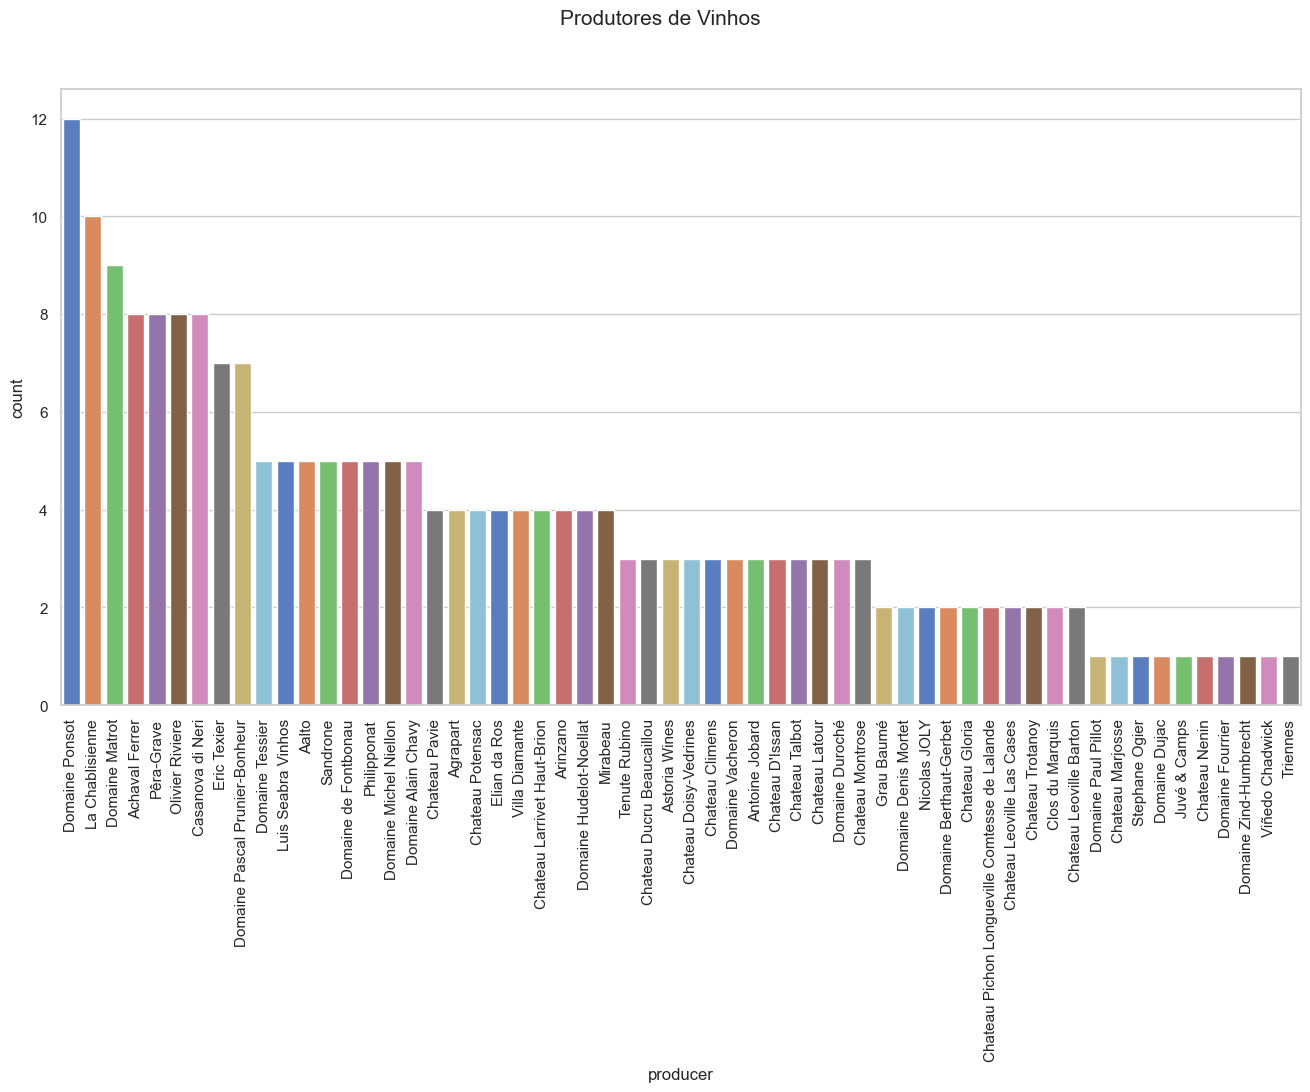

In [266]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(x=df_product.producer, order=df_product.producer.value_counts().index, palette = sns.color_palette("muted"));
plt.xticks(rotation=90)
fig.suptitle("Produtores de Vinhos", fontsize = 15)
plt.show();

Veremos agora a **quantidade de vinhos por país**.

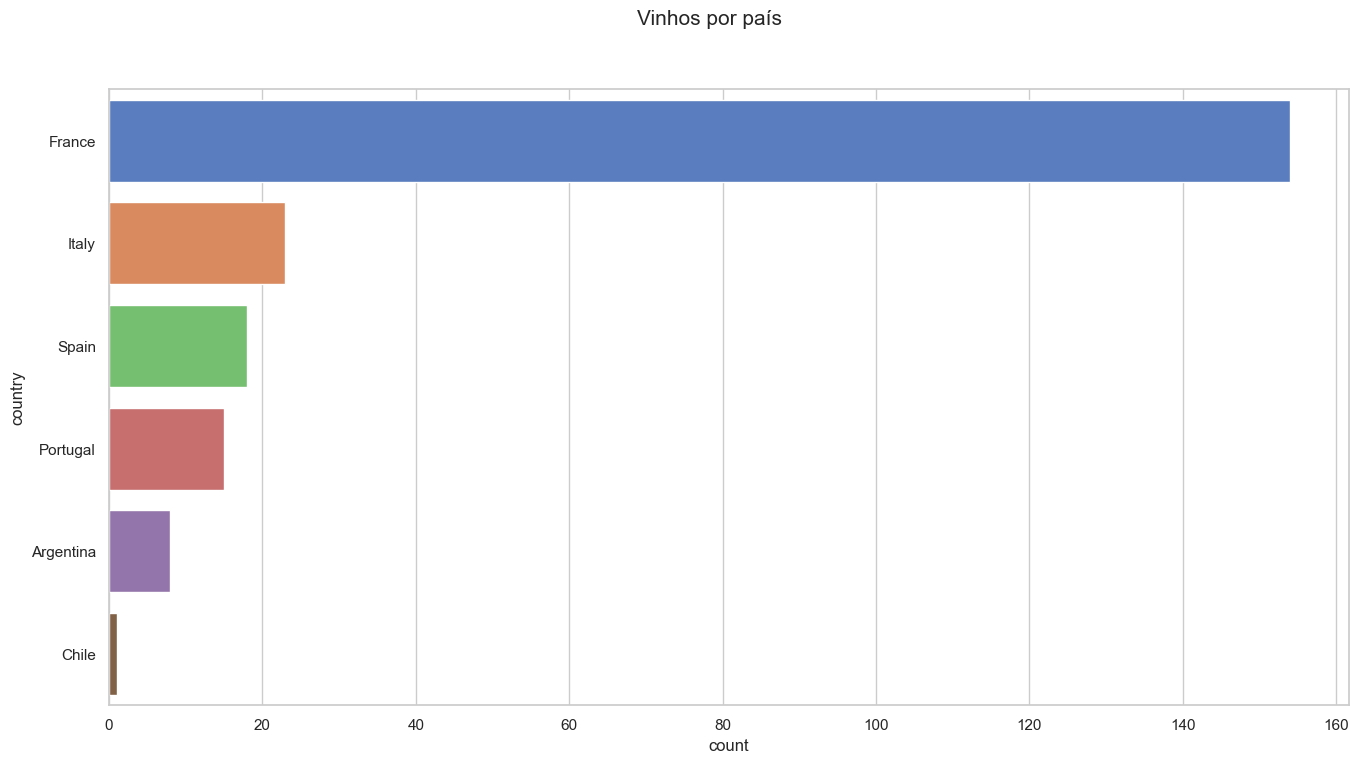

In [267]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(y=df_product.country, order=df_product.country.value_counts().index, palette = sns.color_palette("muted"));
fig.suptitle("Vinhos por país", fontsize = 15)
plt.show();

No dataset o país prevalecente é **França**, seguido de **Itália** e **Espanha**.

Veremos agora a maior quantidade de vinhos por região.

In [268]:
df_product.region.value_counts()

Burgundy            70
Bordeaux            47
Rhone               13
Champagne            9
Alentejo             8
Rioja                8
Toscana              8
Mendoza              8
Douro                7
Provence             5
Ribera del Duero     5
Loire Valley         5
Piedmont             5
Sud Ouest            4
Campania             4
Navarra              4
Veneto               3
Puglia               3
Alsace               1
Penedès              1
Maipo                1
Name: region, dtype: int64

As regiões prevalecentes são **Burgundy**, **Bordeaux**, **Rhone** e **Champagne**.

Veremos agora a safra com maior quantidade de vinhos por **safra**, exluindo aqueles que não possuem safra identificada.

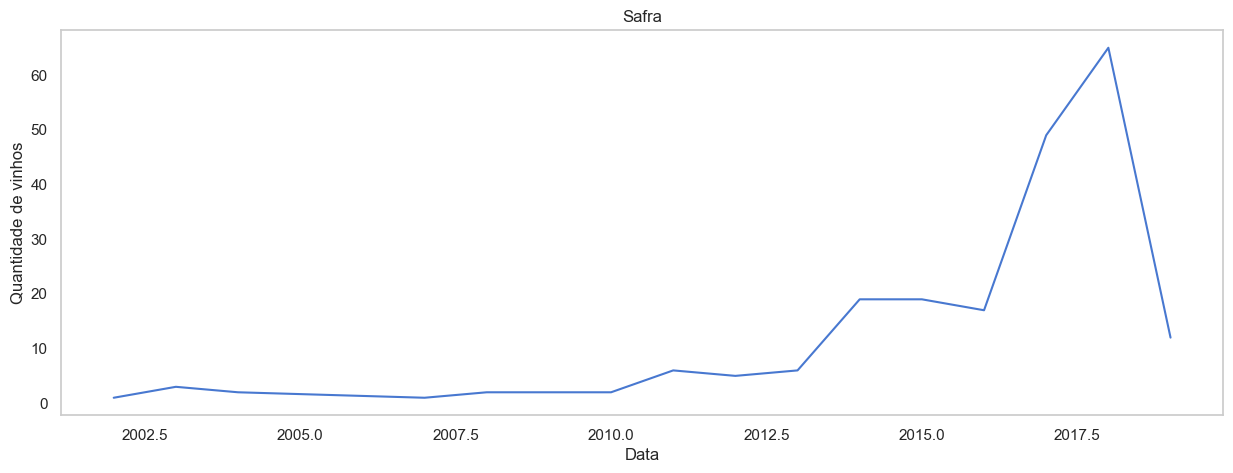

In [269]:
df_copy = df_product.loc[df_product.vintage != 0]

fig = plt.gcf()
fig.set_size_inches(15, 5)
sns.set(style="whitegrid", palette = 'muted')

ax = sns.lineplot(
    x=df_copy.vintage.value_counts().index, y=df_copy.vintage.value_counts().values,
);

ax.grid(False)
ax.set(xlabel='Data', ylabel='Quantidade de vinhos')
ax.set_title("Safra")
plt.show()

Pode-se observar que no dataset, há maiores quantidades de vinhos a partir da safra de 2015.

Vejamos também a quantidade por tipos de vinhos.

In [270]:
df_product.kind.value_counts()

red               132
white              69
sparkling          10
rose                5
rose sparkling      3
Name: kind, dtype: int64

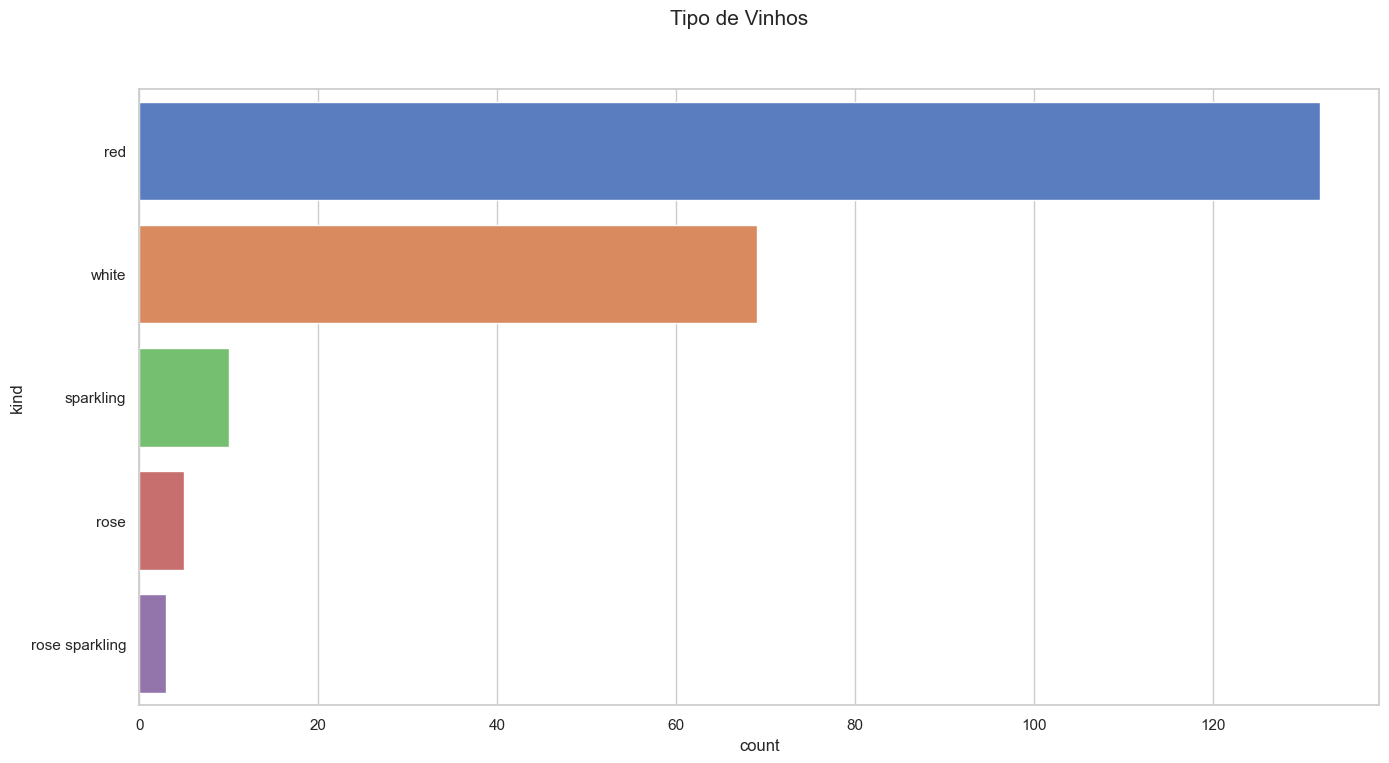

In [271]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(y=df_product.kind, order=df_product.kind.value_counts().index, palette = sns.color_palette("muted"));
fig.suptitle("Tipo de Vinhos", fontsize = 15)
plt.show();

No dataset, há maior prevalência de vinhos **tintos**, **brancos** e **espumante**.

Iremos observar informações estatísticas do dataset.

In [272]:
df_product[['vintage', 'price_brl', 'price_usd']].describe()

,vintage,price_brl,price_usd
count,219.000000,219.000000,219.000000
mean,1942.182648,967.617352,167.407808
std,379.055337,1409.588217,243.873780
min,0.000000,52.800000,9.130000
25%,2014.000000,264.300000,45.725000
50%,2017.000000,509.400000,88.130000
75%,2018.000000,949.200000,164.220000
max,2019.000000,10992.000000,1901.730000


Pode-se observar que:
    
* A mediana da safra está em 2017 e o valor máximo em 2019.
* O preço mínimo é 52 reais e o máximo 10.992.

Observaremos um boxplot do preço de vinhos.

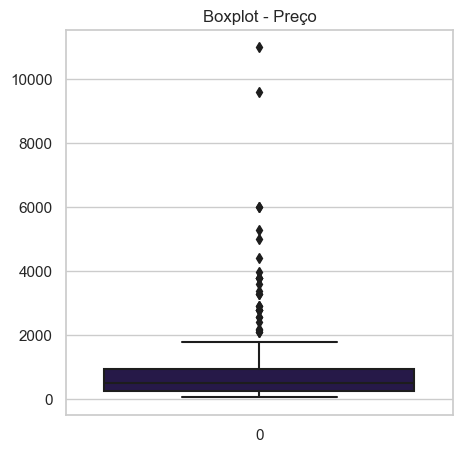

In [273]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_palette("magma")
sns.boxplot(df_product.price_brl, ax = ax);
ax.set_title("Boxplot - Preço");

Há alguns **outliers** referente ao **preço**. Agruparemos os vinhos mais caros por tipo, e o top 5 de vinhos mais caros.

In [274]:
# vinhos mais caros por tipos
df_product.groupby(['kind']).price_brl.max().sort_values(ascending = False)

kind
red               10992.0
white              3294.0
sparkling          1548.0
rose sparkling      899.4
rose                285.0
Name: price_brl, dtype: float64

Os vinhos com preço maior são tintos, brancos e espumante, respectivamente.

In [275]:
# top 5 vinhos mais caros
df_product.sort_values('price_brl', ascending = False)[:5]

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
93,94,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,Domaine Ponsot,France,Burgundy,2017,red,10992.0,1901.73
116,117,Latour,Chateau Latour,France,Bordeaux,2002,red,9594.0,1659.86
142,143,Château Pavie,Chateau Pavie,France,Bordeaux,2010,red,5999.4,1037.96
91,92,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,Domaine Ponsot,France,Burgundy,2007,red,5994.0,1037.02
92,93,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,Domaine Ponsot,France,Burgundy,2017,red,5292.0,915.57


In [276]:
df_store

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
1,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,11
2,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,14
3,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
4,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10
...,...,...,...,...,...,...,...,...,...,...,...
720066,219,Achaval-Ferrer Blend De Fincas Edição Limitada,Achaval Ferrer,Argentina,Mendoza,2014,red,999.0,172.84,3,71
720067,219,Achaval-Ferrer Blend De Fincas Edição Limitada,Achaval Ferrer,Argentina,Mendoza,2014,red,999.0,172.84,3,28
720068,219,Achaval-Ferrer Blend De Fincas Edição Limitada,Achaval Ferrer,Argentina,Mendoza,2014,red,999.0,172.84,3,75
720069,219,Achaval-Ferrer Blend De Fincas Edição Limitada,Achaval Ferrer,Argentina,Mendoza,2014,red,999.0,172.84,3,135


O vinho mais caro custa **10.992** reais, chamado *Domaine Ponsot Clos de La Roche*, da **França**, região de *Burgundy* da safra de **2017**. 

Visualizaremos agora os dados referentes às vendas. Para isso, irei unir o dataframe **store**, com o dataframe previamente analizado. 

In [279]:
store.rename(columns= {'item': 'item_id'}, inplace=True)
store.item_id = store.item_id.astype(str)

df_product['item_id'] = df_product['item_id'].astype(str)
store = df_product.merge(store, on='item_id', how='right')

store['date'] = pd.to_datetime(store['date'])
store.index = store['date']
store.drop('date', axis=1, inplace=True)

print(store.shape)
store.head()

(720071, 11)


,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales
date,,,,,,,,,,,
2018-01-01,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
2018-01-02,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,11
2018-01-03,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,14
2018-01-04,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
2018-01-05,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10


In [280]:
# distribuição estatística das vendas
round(store.describe(),2)

,vintage,price_brl,price_usd,store,sales
count,720071.00,720071.00,720071.00,720071.00,720071.00
mean,1942.18,967.62,167.41,2.00,70.59
std,378.19,1406.37,243.32,0.82,41.36
min,0.00,52.80,9.13,1.00,1.00
25%,2014.00,259.20,44.84,1.00,35.00
50%,2017.00,509.40,88.13,2.00,67.00
75%,2018.00,949.20,164.22,3.00,104.00
max,2019.00,10992.00,1901.73,3.00,196.00
